### Notebook to compute intrinsic alignments of dark matter halos from the N-body simulation AbacusSummit

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value
from astropy import units as u

import treecorr

from scipy.ndimage import gaussian_filter

### Cosmological parameters

In [6]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3) ; h=0.7

### Function required for further work

In [7]:
# Computing complex elipticity
def e_complex(a,b,r):
    abs_e = (1-(b/a)) / (1+(b/a))
    e1 = abs_e*np.cos(2*r)
    e2 = abs_e*np.sin(2*r)
    return e1, e2

# Format ellipsoid parameters to match Abacus (eigenvectors and values must be in order of least to greatest)
def format_ellipsoid(eigenvectors, eigenvalues, position = np.asarray([0,0,0])):
    
    el = Table()
    el['sigman_eigenvecsMin_L2com'] = eigenvectors[0]
    el['sigman_eigenvecsMid_L2com'] = eigenvectors[1]
    el['sigman_eigenvecsMaj_L2com'] = eigenvectors[2]
    
    el['sigman_L2com'] = np.sqrt(eigenvalues)
    
    return el

### Abacus halos (z=0.575)

Snapshot z=0.575, box of size 2 Gpc, base_c000_ph000

In [4]:
# Halo catalog 
halos_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/model_2/Abacus_halos_z0.575.fits')
halos_table


# Selecting a certain number of halo
nb_halos=200_000

random_indices = np.random.choice(len(halos_table), size=nb_halos, replace=False)
halos_table = halos_table[random_indices]


# Positions in 3D
x = halos_table['x_L2com'][:,0] * u.Mpc
y = halos_table['x_L2com'][:,1] * u.Mpc
z = halos_table['x_L2com'][:,2] * u.Mpc

x_val = x.value ; y_val = y.value ; z_val = z.value

### Model : population of halos by galaxies

In [8]:
# Function to generate a population of galaxies that live into Abacus halos
# Returns the eigenvectors inherited from the host-halos and the eigenvalues modified by the tau_B and tau_C parameters

def population_3D (mu_tau_A, mu_tau_B, mu_tau_C, 
                   sigma_tau_A, sigma_tau_B, sigma_tau_C, r_tau,
                   el=halos_table, nb_halos=nb_halos) : 

    halos_table2 = el.copy()
    axis_orig = np.array(halos_table2['sigman_L2com']**2)

    valid_axis = []

    while len(valid_axis) < nb_halos:
    
        taus = np.random.multivariate_normal(mean=[mu_tau_A, mu_tau_B, mu_tau_C], 
                                             
                                    cov=[[sigma_tau_A**2, r_tau * sigma_tau_A * sigma_tau_B, r_tau * sigma_tau_A * sigma_tau_C],
                                    [r_tau * sigma_tau_A * sigma_tau_B, sigma_tau_B**2, r_tau * sigma_tau_B * sigma_tau_C],
                                    [r_tau * sigma_tau_A * sigma_tau_C, r_tau * sigma_tau_B * sigma_tau_C, sigma_tau_C**2]],
                                    
                                    size=nb_halos)
    
        tau_A2 = np.clip(taus[:, 0], 0, 1)
        tau_B2 = np.clip(taus[:, 1], 0, 1)
        tau_C2 = np.clip(taus[:, 2], 0, 1)

        axis = axis_orig.copy()
        axis[:, 0] *= tau_A2
        axis[:, 1] *= tau_B2
        axis[:, 2] *= tau_C2

        Ag, Bg, Cg = axis[:, 0], axis[:, 1], axis[:, 2]
        mask = (Bg / Ag <= 1) & (Cg / Ag <= 1) & (Bg >= Cg) & (Bg > 0) & (Cg > 0)
        filtered = axis[mask]

        to_add = min(nb_halos - len(valid_axis), filtered.shape[0])
        valid_axis.extend(filtered[:to_add])


    axis = np.array(valid_axis) 
   
    
    eigenvecs_Min = halos_table2['sigman_eigenvecsMin_L2com'][:len(axis)]
    eigenvecs_Mid = halos_table2['sigman_eigenvecsMid_L2com'][:len(axis)]
    eigenvecs_Max = halos_table2['sigman_eigenvecsMaj_L2com'][:len(axis)]

    eigenvectors = np.stack((eigenvecs_Min, eigenvecs_Mid, eigenvecs_Max), axis=1)

    ellipses = np.array([format_ellipsoid(eigenvectors[i, :, :], axis[i, :]) for i in range(nb_halos)])
    ellipses = np.array(ellipses)

    evcl = np.array([ellipses['sigman_eigenvecsMaj_L2com'], ellipses['sigman_eigenvecsMid_L2com'], ellipses['sigman_eigenvecsMin_L2com']])
    evcl=np.transpose(evcl, (1, 0, 2))
    evls = ellipses['sigman_L2com']**2 

    
    return evcl, evls

### Projection of 3D halo shapes in 2D

In [9]:
def projection (evcl, evls, p_axis=''):

    # Projection 3D => 2D
    if p_axis=='x': # Projection perpendicular to the LOS
        K = np.sum(evcl[:,:,0][:,:,None]*(evcl/evls[:,None]), axis=1)
        r = evcl[:,:,2] - evcl[:,:,0] * K[:,2][:,None] / K[:,0][:,None]
        s = evcl[:,:,1] - evcl[:,:,0] * K[:,1][:,None] / K[:,0][:,None] 

    if p_axis=='y': # Projection along the LOS
        K = np.sum(evcl[:,:,1][:,:,None] * (evcl/evls[:,None]), axis=1)
        r = evcl[:,:,0] - evcl[:,:,1] * K[:,0][:,None] / K[:,1][:,None]
        s = evcl[:,:,2] - evcl[:,:,1] * K[:,2][:,None] / K[:,1][:,None]


    # Coefficients A,B,C (eq 23 of (2))
    A1 = np.sum(r**2 / evls, axis=1)
    B1 = np.sum(2*r*s / evls, axis=1)
    C1 = np.sum(s**2 / evls, axis=1)


    # Axis a_p,b_p and orientation angle r_p of the projected galaxy
    r_p = np.pi / 2 + np.arctan2(B1,A1-C1)/2
    a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*r_p)))
    b_p = 1/np.sqrt(A1+C1-(1/a_p**2))


    # Projected ellipticity
    e1, e2 = e_complex(a_p, b_p, r_p)

    return e1, e2

### Simulator (model => $e_1,e_2$)

In [10]:
# Function to compute the projected ellipticities of the halos after projection of their 3D shape


def simulator(theta, 
                el=halos_table,
                nb_halos=nb_halos, 
                p_axis='y', # The direction of projection (here 'y' denotes by convention the direction of the line-of-sight)
                e_bins=np.linspace(0,1,100) # The number of bins for the histogram of e_counts (output)
               ):

    mu_tau_A, mu_tau_B, mu_tau_C, sigma_tau_A, sigma_tau_B, sigma_tau_C, r_tau = theta

    evcl, evls = population_3D (mu_tau_A, mu_tau_B, mu_tau_C, sigma_tau_A, sigma_tau_B, sigma_tau_C, r_tau, el, nb_halos)
    
    e1, e2 = projection (evcl, evls, p_axis) 

    
    return e1, e2



e1_halos, e2_halos = simulator([1,1,1,0,0,0,0], el=halos_table)


halos_table['e1']= e1_halos ; halos_table['e2']= e2_halos

### Computing halo intrinsic alignments (using TreeCorr https://ui.adsabs.harvard.edu/abs/2015ascl.soft08007J/abstract)

In [25]:
# Function that computes the 2-point correlation function xi_g+ and xi_gx for the Abacus halos projected shapes and the associated variances (using Jackknife)

def compute_halo_intrinsic_alignments (x_val, y_val, z_val, 
                                       
                                       e1, e2, 

                                       pi_max, 
                                         
                                       rp_min, rp_max,

                                       bin_type,
                                        
                                       nrp=25, npi=50,
                                       
                                       npatch=20):
    
    # Catalog of halos
    halo_shapes = treecorr.Catalog(x=x_val, y=y_val, z=z_val, g1=e1, g2=e2, npatch=npatch)

    # Line-of-sight direction
    pi = np.linspace(-pi_max, pi_max, npi)

    xi_gp = [] ; xi_gp = list(xi_gp) ; xi_gc = [] ; xi_gc = list(xi_gc)
    var = [] ; var = list(var) ; rp = [] ; rp = list(rp)

    for i in np.arange(0, npi-1):

        ng = treecorr.NGCorrelation(nbins=nrp, 
                                min_sep = rp_min,
                                max_sep = rp_max,
                                min_rpar = pi[i],
                                max_rpar = pi[i+1],
                                bin_type=bin_type,
                                bin_slop=0.1,
                                angle_slop=0.1,
                                var_method='jackknife',
                                cross_patch_weight='simple')
        ng.process(halo_shapes, halo_shapes, metric ='Rperp')

        xi_p, xi_c, var2 = ng.calculateXi(rg=None) ; r=ng.meanlogr

        xi_gp.append(xi_p) ; xi_gc.append(xi_c) ; var.append(var2) ; rp.append(r)

    xi_gp_halos=np.array(xi_gp) ; xi_gc_halos=np.array(xi_gc) ; var_halos = np.array(var) ; r_halos = np.array(rp)

    return xi_gp_halos, xi_gc_halos, var_halos, r_halos

In [12]:
xi_gp_halos, xi_gc_halos, var_halos, r_halos = compute_halo_intrinsic_alignments (x_val, y_val, z_val, 
                                                                                  
                                                                                  e1_halos, e2_halos, 

                                                                                  pi_max = 60, 
                                         
                                                                                  rp_min=0.1, rp_max = 60.,

                                                                                  bin_type='Linear',
                                        
                                                                                  nrp=25, npi=50,
                                       
                                                                                  npatch=20)

### Plotting the correlation functions $\xi_{g+}(r_p,\Pi)$ and $\xi_{g\times}(r_p,\Pi)$

In [13]:
# Function to plot the correlation functions in the rp-Pi plane

def plotting_correlation_function(xi_gn_p_results, xi_gn_x_results, rmin=60, sigma=2, 
                                  contourf=True, vmin=None, vmax=None, log=False, title_p='', title_x=''):


    smoothed_xi_gn_p_results = gaussian_filter(xi_gn_p_results, sigma=sigma)
    smoothed_xi_gn_x_results = gaussian_filter(xi_gn_x_results, sigma=sigma)

    if log:
        print('do nothing')
    else:
        smoothed_xi_gn_p_results[ smoothed_xi_gn_p_results < vmin ] = vmin
        smoothed_xi_gn_x_results[ smoothed_xi_gn_x_results < vmin ] = vmin

        smoothed_xi_gn_p_results[ smoothed_xi_gn_p_results > vmax ] = vmax
        smoothed_xi_gn_x_results[ smoothed_xi_gn_x_results > vmax ] = vmax



    plt.figure(figsize=(12, 8))


    plt.subplot(121)

    if contourf:
        plt.contourf(smoothed_xi_gn_p_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)
    else:
        plt.imshow(smoothed_xi_gn_p_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)
    
    plt.xlim(0, rmin)
    plt.ylim(-rmin, rmin)
    plt.gca().set_aspect('equal')
    plt.xticks([20, 40, 60]) 
    colorbar = plt.colorbar()
    colorbar.ax.tick_params(labelsize=13)
    plt.ylabel(r'$\Pi$ [Mpc]', fontsize=15)
    plt.xlabel(r'$r_\mathrm{p}$ [Mpc]', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title(title_p, fontsize=18)
    #plt.savefig('Abacus_halos_xi_gp.pdf', bbox_inches='tight')



    plt.subplot(122)
    if contourf:
        plt.contourf(smoothed_xi_gn_x_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)
    else:
        plt.imshow(smoothed_xi_gn_x_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)

    plt.xlim(0, rmin)
    plt.ylim(-rmin, rmin)
    plt.gca().set_aspect('equal')
    plt.xticks([20, 40, 60]) 
    colorbar = plt.colorbar()
    colorbar.ax.tick_params(labelsize=13)
    plt.ylabel(r'$\Pi$ [Mpc]', fontsize=15)
    plt.xlabel(r'$r_\mathrm{p}$ [Mpc]', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title(title_x, fontsize=18)
    #plt.savefig('Abacus_halos_xi_gc.pdf', bbox_inches='tight')

    plt.tight_layout()
    plt.show()

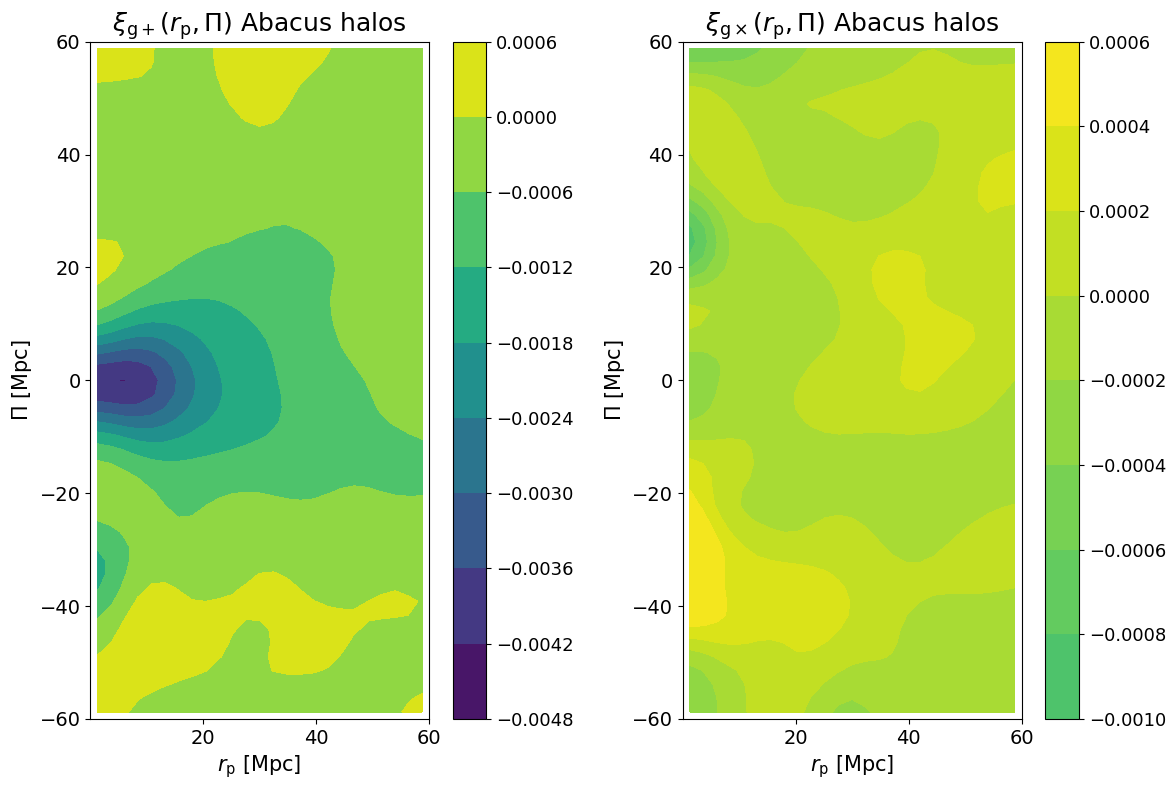

In [15]:
plotting_correlation_function(xi_gp_halos.T, xi_gc_halos.T, rmin=60, sigma=2, 
                              contourf=True, vmin=-0.0048, vmax=0.0006, log=False, 
                              title_p=r'$\xi_{\mathrm{g+}}(r_\mathrm{p},\Pi)$ Abacus halos', 
                              title_x=r'$\xi_{\mathrm{g\times}}(r_\mathrm{p},\Pi)$ Abacus halos')

### Computing $w_{\mathrm{g+}}$ and $w_{\mathrm{g\times}}$

$w_{\mathrm{g+}}(r_\mathrm{p}) = \int_{-\Pi_{\mathrm{max}}}^{\Pi_{\mathrm{max}}}d\Pi~\xi_{\mathrm{g+}}(r_\mathrm{p},\Pi)$

$w_{\mathrm{g\times}}(r_\mathrm{p}) = \int_{-\Pi_{\mathrm{max}}}^{\Pi_{\mathrm{max}}}d\Pi~\xi_{\mathrm{g+}}(r_\mathrm{p},\Pi)$

In [26]:
xi_gp_halos, xi_gc_halos, var_halos, r_halos = compute_halo_intrinsic_alignments (x_val, y_val, z_val, 
                                                                                  
                                                                                  e1_halos, e2_halos, 

                                                                                  nrp=25, npi=50,

                                                                                  pi_max = 20, 
                                         
                                                                                  rp_min=0.1, rp_max = 200.,
                                       
                                                                                  npatch=20,
                                                                                  
                                                                                  bin_type='Log')

nrp=25

wgp_halos = np.zeros(nrp) ; sum_var_gp_halos=np.zeros(nrp)
wgc_halos = np.zeros(nrp) ; sum_var_gc_halos=np.zeros(nrp)

# Summing over bins of Pi to get the projected correlation functions w_g+ and w_gx
for i in range (nrp):
    wgp_halos[i] = abs(np.sum(xi_gp_halos[:,i])) ; sum_var_gp_halos[i]= np.sum(var_halos[:,i])
    wgc_halos[i] = abs(np.sum(xi_gc_halos[:,i])) ; sum_var_gc_halos[i]= np.sum(var_halos[:,i])


sigma_gp_halos = np.sqrt(sum_var_gp_halos)
sigma_gc_halos = np.sqrt(sum_var_gc_halos)

### Plotting $r_p\times w_{g+}(r_p)$ and $r_p\times w_{g\times}(r_p)$

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_39363/1381474313.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


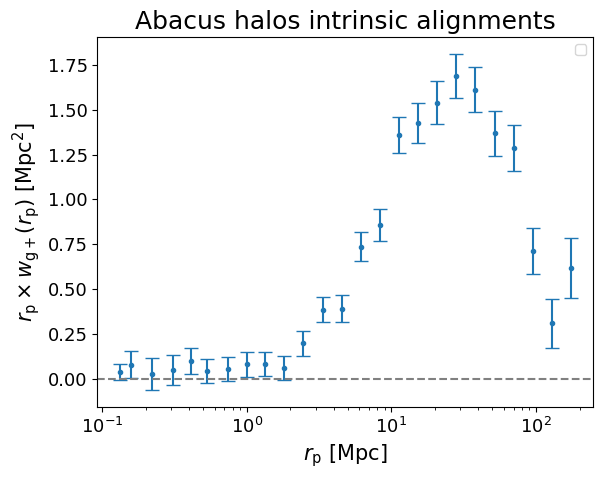

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_39363/1381474313.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


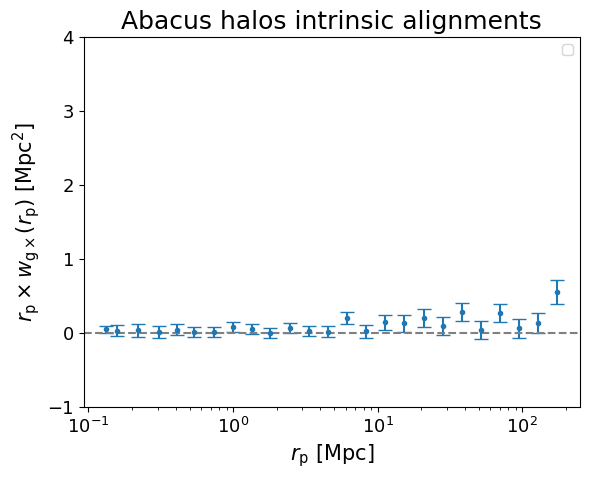

In [27]:
plt.errorbar(np.exp(r_halos[0,:]), np.exp(r_halos[0,:])*wgp_halos, yerr= np.exp(r_halos[0,:])*sigma_gp_halos, fmt='o', markersize=3, capsize=5)
plt.xscale('log')
plt.xlabel(r'$r_\mathrm{p}~[\mathrm{Mpc}]$', fontsize=15)
plt.ylabel(r'$r_\mathrm{p} \times w_{\mathrm{g+}}(r_\mathrm{p})~[\mathrm{Mpc}^2]$', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.title("Abacus halos intrinsic alignments", fontsize=18)
plt.savefig('Abacus_halos_wgp.pdf', bbox_inches='tight')
plt.show()



plt.errorbar(np.exp(r_halos[0,:]), np.exp(r_halos[0,:])*wgc_halos, yerr= np.exp(r_halos[0,:])*sigma_gc_halos, fmt='o', markersize=3, capsize=5)
plt.xscale('log')
plt.xlabel(r'$r_\mathrm{p}~[\mathrm{Mpc}$]', fontsize=15)
plt.ylabel(r'$r_\mathrm{p} \times w_{\mathrm{g\times}}(r_\mathrm{p})~[\mathrm{Mpc}^2]$', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylim(-1,4)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.title("Abacus halos intrinsic alignments", fontsize=18)
plt.savefig('Abacus_halos_wgc.pdf', bbox_inches='tight')
plt.show()